In [37]:
import time
import numpy as np
import pandas as pd
import os
import ast
import torch

import sys
sys.path.append('/home/ngrav/project/')
from wearables.scripts import data as weardata
from wearables.scripts import eval_ as weareval

import matplotlib.pyplot as plt
import seaborn as sns

plt.rc('font', size = 9)
plt.rc('font', family='sans serif')
plt.rcParams['pdf.fonttype']=42
plt.rcParams['ps.fonttype']=42
plt.rcParams['legend.frameon']=False
plt.rcParams['axes.grid']=False
plt.rcParams['legend.markerscale']=0.5
plt.rcParams['savefig.dpi']=600
sns.set_style("ticks")

# load results files

In [2]:
pfp = '/home/ngrav/project/wearables/results/'

# result files
result_files = {
    'GRU': (os.path.join(pfp, 'eval_test_v43_nalab3.csv'), None),
    'InceptionTime': (os.path.join(pfp, 'eval_v52.csv'), None),
    'CNN': (os.path.join(pfp, 'eval_test_v43.csv'), None),
    'nonDL': (os.path.join(pfp, 'model_cmp_nonDL.csv'),None),
}
result_files = {k:(v[0], pd.read_csv(v[0], index_col=0)) for k,v in result_files.items()}

# load up to date md
md = pd.read_csv(os.path.join(pfp, 'md_v52_220111.csv'), index_col=0)

# store remainder
results = pd.DataFrame()

In [3]:
md.head()

,record_id,age_enroll,marital,gestage_by,insur,ethnicity,race,bmi_1vis,prior_ptb_all,fullterm_births,...,ISm,IVm,min_rest,ave_logpseudocount_wake,ave_logpseudocount_sleep,ave_logpseudocount_wknd,ave_logpseudocount_wkday,ave_logpseudocount_day,ave_logpseudocount_night,Pre-term birth
1024_10,1024,23.0,0.0,0.0,5.0,0.0,1.0,21.378954,0.0,1.0,...,0.201134,0.281756,7954.0,5.454885,0.151541,2.633760,0.724612,1.945987,0.594180,False
2180_35,2180,34.0,1.0,1.0,3.0,0.0,0.0,31.732640,0.0,0.0,...,0.455816,0.574621,5751.0,5.124668,0.826768,2.613515,2.696182,2.933929,2.411196,False
2180_12,2180,34.0,1.0,1.0,3.0,0.0,0.0,31.732640,0.0,0.0,...,0.160471,1.822176,10075.0,5.165496,0.001474,0.000000,0.005650,0.008072,0.000000,False
2180_26,2180,34.0,1.0,1.0,3.0,0.0,0.0,31.732640,0.0,0.0,...,0.486912,0.549746,5863.0,5.202776,0.819541,2.526396,2.704035,3.215078,2.091485,False
2148_34,2148,34.0,1.0,2.0,3.0,0.0,0.0,22.406605,0.0,1.0,...,0.615433,0.284855,5069.0,5.325096,0.606202,2.915334,2.966768,4.487991,1.416154,False


# single results file

file by file

## nonDL

In [4]:
dt = result_files['nonDL'][1].reset_index()#.loc[~result_files['InceptionTime'][1].index.isna()].reset_index()
dt.head()

,index,mae,mape,rho,P_rho,model
0,0,8.583740,0.638283,0.244912,3.741856e-08,kNN
1,1,8.250400,0.599591,0.256477,5.947150e-09,kNN
2,2,8.379350,0.573448,0.215886,6.221306e-07,kNN
3,3,8.658431,0.629391,0.219734,5.401174e-07,kNN
4,4,8.343918,0.656512,0.265145,3.017894e-09,kNN


In [5]:
for i in dt['model'].unique():
    print(i)

kNN
RandomForest
Gradient Boosting (LightGBM)
TimeSeriesForest


In [6]:
for i, idx in enumerate(dt.index):
    if 'knn' in dt.loc[idx, 'model'].lower():
        results = results.append(
            pd.DataFrame({
                'Model': 'kNN',
                'Trial': i+1,
                'MAE': float(dt.loc[idx, 'mae']),
                'Rho': float(dt.loc[idx, 'rho']),
            }, index=['kNN_{}'.format(i+1)]))
    elif 'random' in dt.loc[idx, 'model'].lower():
        results = results.append(
            pd.DataFrame({
                'Model': 'RandomForest',
                'Trial': i+1,
                'MAE': float(dt.loc[idx, 'mae']),
                'Rho': float(dt.loc[idx, 'rho']),
            }, index=['RF_{}'.format(i+1)]))
    elif 'gradient' in dt.loc[idx, 'model'].lower():
        results = results.append(
            pd.DataFrame({
                'Model': 'Gradient Boosting',
                'Trial': i+1,
                'MAE': float(dt.loc[idx, 'mae']),
                'Rho': float(dt.loc[idx, 'rho']),
            }, index=['LightGBM_{}'.format(i+1)]))
    elif 'timeseriesforest' in dt.loc[idx, 'model'].lower():
        results = results.append(
            pd.DataFrame({
                'Model': 'TimeSeriesForest',
                'Trial': i+1,
                'MAE': float(dt.loc[idx, 'mae']),
                'Rho': float(dt.loc[idx, 'rho']),
            }, index=['TSForest_{}'.format(i+1)]))


## GRU/LSTM

In [7]:
dt = result_files['GRU'][1].loc[~result_files['GRU'][1].index.isna()].reset_index()
dt.head()

,index,exp_trial,y,yhat,loss,mae,rho,P_rho
0,0.0,gruv43l1l2_GA_1,"tensor([29., 30., 23., 15., 35., 10., 14., 12....","tensor([18.9361, 19.0760, 19.4239, 18.9864, 18...",96.95942687988281,8.839193344116211,0.008203120813113038,0.8231234877323702
1,0.0,gruv43l1l2_GA_2,"tensor([ 4., 16., 32., 8., 22., 28., 34., 36....","tensor([19.4045, 19.1761, 19.0675, 19.0093, 19...",100.22972106933594,8.723615646362305,-0.021229088328782612,0.5687467014777923
2,0.0,gruv43l1l2_GA_3,"tensor([33., 22., 31., 12., 31., 22., 9., 24....","tensor([19.2757, 19.0036, 19.9316, 19.0063, 19...",116.82705688476562,8.833919525146484,0.023761384912903107,0.5246961372041654
3,0.0,gruv43l1l2_GA_4,"tensor([23., 26., 32., 23., 7., 8., 30., 14....","tensor([19.4152, 18.7340, 19.5195, 18.7563, 19...",92.31097412109375,8.824865341186523,-0.07819858362409428,0.032252746417479175
4,0.0,gruv43l1l2_GA_5,"tensor([10., 28., 22., 24., 25., 23., 12., 10....","tensor([19.0927, 19.3744, 18.8973, 19.2219, 18...",96.99552154541016,8.749350547790527,-0.03502765379904075,0.341005047154436


In [8]:
for i, idx in enumerate(dt.index):
    if 'gruv43' in dt.loc[idx, 'exp_trial']:
        results = results.append(
            pd.DataFrame({
                'Model': 'GRU',
                'Trial': i+1,
                'MAE': float(dt.loc[idx, 'mae']),
                'Rho': float(dt.loc[idx, 'rho']),
            }, index=['RNN_{}'.format(i+1)]))


## CNN

In [9]:
dt = result_files['CNN'][1].loc[~result_files['CNN'][1].index.isna()].reset_index()
dt.head()

,index,exp_trial,y,yhat,loss,mae,rho,P_rho
0,0.0,cnnv43l1l2_GA_1,"tensor([30., 32., 23., 33., 24., 8., 34., 36....","tensor([19.3760, 23.0334, 18.3788, 19.4221, 21...",95.67539978027344,8.292655944824219,0.3207704272544278,3.050761464702594e-19
1,0.0,cnnv43l1l2_GA_2,"tensor([22., 23., 34., 7., 6., 19., 12., 8....","tensor([21.4751, 23.2352, 23.1129, 19.8478, 12...",126.35601043701172,7.991382122039795,0.25844017917812334,1.0007223758729578e-12
2,0.0,cnnv43l1l2_GA_3,"tensor([29., 13., 25., 8., 12., 11., 24., 13....","tensor([20.2638, 27.6862, 28.1675, 14.4703, 22...",126.07781982421875,7.9508490562438965,0.3178111729827553,2.9912436159576756e-19
3,0.0,cnnv43l1l2_GA_4,"tensor([36., 11., 23., 16., 32., 23., 24., 7....","tensor([24.0591, 21.9778, 15.3210, 28.9333, 24...",102.42086791992188,7.973170280456543,0.26375511431240073,2.5361886846314714e-13
4,0.0,cnnv43l1l2_GA_5,"tensor([24., 7., 31., 24., 19., 24., 26., 8....","tensor([18.2850, 16.2654, 19.0980, 20.9922, 27...",143.9127960205078,7.77083158493042,0.3184541958350933,9.212774350819888e-19


In [10]:
for i in dt['exp_trial'].unique():
    print(i)

cnnv43l1l2_GA_1
cnnv43l1l2_GA_2
cnnv43l1l2_GA_3
cnnv43l1l2_GA_4
cnnv43l1l2_GA_5
cnnv43l1l2_GA_6
cnnl1l2rand_GA_1
cnnl1l2rand_GA_2
cnnl1l2rand_GA_3
cnnl1l2rand_GA_4
cnnl1l2rand_GA_5
cnnl1l2rand_GA_6


In [11]:
for i, idx in enumerate(dt.index):
    if 'cnnv43l1l2' in dt.loc[idx, 'exp_trial']:
        results = results.append(
            pd.DataFrame({
                'Model': 'VGG-1D',
                'Trial': i+1,
                'MAE': float(dt.loc[idx, 'mae']),
                'Rho': float(dt.loc[idx, 'rho']),
            }, index=['CNN_{}'.format(i+1)]))


## IT

In [30]:
dt = result_files['InceptionTime'][1].loc[~result_files['InceptionTime'][1].index.isna()].reset_index()
dt.head()

,index,exp_trial,y,yhat,loss,mae,rho,P_rho
0,0.0,biasvarp0.05_InceptionTime_GA_1,"tensor([26., 7., 24., ..., 32., 34., 31.])","tensor([17.2750, 20.5857, 23.2773, ..., 18.89...",111.48644256591797,8.557896614074707,0.155908691958009,2.1051444826013188e-14
1,0.0,biasvarp0.3_InceptionTime_GA_1,"tensor([25., 9., 6., ..., 12., 9., 24.])","tensor([19.7858, 14.9552, 10.4758, ..., 11.82...",73.80008697509766,7.917028427124023,0.3269238113363961,2.2207540281673376e-49
2,0.0,biasvarp0.1_InceptionTime_GA_1,"tensor([35., 18., 36., ..., 10., 21., 8.])","tensor([18.0156, 19.1053, 21.6982, ..., 21.05...",116.56275939941406,8.3196382522583,0.20423674052139532,5.481809149130794e-23
3,0.0,biasvarp0.7_InceptionTime_GA_1,"tensor([12., 28., 20., ..., 34., 31., 34.])","tensor([19.3619, 15.8853, 17.9283, ..., 23.13...",110.9866714477539,7.334397792816162,0.46029171181601747,3.503890322105072e-67
4,0.0,biasvarp0.4_InceptionTime_GA_1,"tensor([33., 8., 33., ..., 17., 13., 35.])","tensor([14.5122, 20.2064, 15.5786, ..., 14.02...",135.69009399414062,8.243865013122559,0.27342963382850866,1.0130576390985373e-31


In [36]:
# find bst model
dt.sort_values(by='mae').head()

,index,exp_trial,y,yhat,loss,mae,rho,P_rho
14,0.0,itv52_InceptionTime_GA_5,"tensor([24., 12., 28., 25., 8., 9., 15., 18....","tensor([21.7263, 17.9865, 13.9877, 18.4810, 17...",74.58009338378906,7.269989490509033,0.4577804914621971,1.8707651131349725e-39
3,0.0,biasvarp0.7_InceptionTime_GA_1,"tensor([12., 28., 20., ..., 34., 31., 34.])","tensor([19.3619, 15.8853, 17.9283, ..., 23.13...",110.9866714477539,7.334397792816162,0.46029171181601747,3.503890322105072e-67
7,0.0,biasvarp0.6_InceptionTime_GA_1,"tensor([24., 16., 23., ..., 14., 26., 17.])","tensor([31.5774, 20.1625, 26.7660, ..., 24.06...",66.68151092529297,7.40779972076416,0.40772244806390917,2.606714456122068e-58
16,0.0,itv52_InceptionTime_GA_3,"tensor([36., 34., 35., 4., 13., 12., 22., 10....","tensor([28.1966, 22.3484, 16.3669, 14.0371, 16...",63.08951950073242,7.437720775604248,0.4172512974911048,2.2629464135118816e-33
17,0.0,itv52_InceptionTime_GA_6,"tensor([31., 34., 5., 9., 11., 34., 34., 20....","tensor([22.0438, 23.3604, 18.3152, 11.8106, 17...",68.99295043945312,7.514163970947266,0.3855501474855371,3.937639438280336e-28


In [13]:
for i in dt['exp_trial'].unique():
    print(i)

biasvarp0.05_InceptionTime_GA_1
biasvarp0.3_InceptionTime_GA_1
biasvarp0.1_InceptionTime_GA_1
biasvarp0.7_InceptionTime_GA_1
biasvarp0.4_InceptionTime_GA_1
biasvarp0.2_InceptionTime_GA_1
biasvarp0.8_InceptionTime_GA_1
biasvarp0.6_InceptionTime_GA_1
biasvarp0.9_InceptionTime_GA_1
itv52_InceptionTime_GA_7
itv52_InceptionTime_GA_1
itv52_InceptionTime_GA_4
itv52_InceptionTime_GA_2
itv52_InceptionTime_GA_8
itv52_InceptionTime_GA_5
itv52_InceptionTime_GA_9
itv52_InceptionTime_GA_3
itv52_InceptionTime_GA_6
itrandv52_InceptionTime_GA_7
itrandv52_InceptionTime_GA_4
itrandv52_InceptionTime_GA_1
itrandv52_InceptionTime_GA_8
itrandv52_InceptionTime_GA_5
itrandv52_InceptionTime_GA_2
itrandv52_InceptionTime_GA_9
itrandv52_InceptionTime_GA_6
itrandv52_InceptionTime_GA_3


In [14]:
for i, idx in enumerate(dt.index):
    if 'itrandv52' in dt.loc[idx, 'exp_trial']:
        results = results.append(
            pd.DataFrame({
                'Model': 'InceptionTime (Random)',
                'Trial': i+1,
                'MAE': float(dt.loc[idx, 'mae']),
                'Rho': float(dt.loc[idx, 'rho']),
            }, index=['InceptionTime_rand_{}'.format(i+1)]))


In [15]:
for i, idx in enumerate(dt.index):
    if 'itv52' in dt.loc[idx, 'exp_trial']:
        results = results.append(
            pd.DataFrame({
                'Model': 'Ours',
                'Trial': i+1,
                'MAE': float(dt.loc[idx, 'mae']),
                'Rho': float(dt.loc[idx, 'rho']),
            }, index=['InceptionTime_{}'.format(i+1)]))


# head-to-head summary

In [27]:
def p_encoder(p):
    if p > 0.05:
        label = '' # n.s.
    elif p <= 0.001:
        label = '***'
    elif p <= 0.05 and p > 0.01:
        label = '*'
    elif p <= 0.01 and p > 0.001:
        label = '**'
    else: 
        label = 'Unclassified'
    return label

def summarize_long_table(results_longtab, metrics=['MAE', 'Rho'], group='Model', out_file=None):
    '''
    Arguments:
      results_longtab (pd.DataFrame): assumes that replicates are indicated in a trial col
        but otherwise repeated according to the group colname
    '''
    from scipy.stats import ttest_ind
    summary = pd.DataFrame()
    
    for g in results_longtab[group].unique():
        summary.loc[g, group] = g
        for m in metrics:
            temp = {}
            others = [gg for gg in results_longtab[group].unique() if gg!=g]
            a = results_longtab.loc[results_longtab[group]==g, m].to_numpy()
            summary.loc[g, m] = '{:.2f} ({:.2f})'.format(np.mean(a), np.std(a))
            for gg in others:
                b = results_longtab.loc[results_longtab[group]==gg, m].to_numpy()
                statistic, p = ttest_ind(a, b)
                temp['v.{}'.format(gg)] = (np.max(a) - np.max(b), p)
            # only retain min
            k2keep = min(temp, key=temp.get)
            summary.loc[g, 'Top-1 diff ({})'.format(m)] = '{:.2f} ({})'.format(temp[k2keep][0], k2keep)
            summary.loc[g, 'P ({})'.format(m)] = '{:.2e}{} ({})'.format(temp[k2keep][1], p_encoder(temp[k2keep][1]), k2keep)
    if out_file is not None:
        summary.to_csv(out_file)
    return summary

In [28]:
summarize_long_table(results, out_file=os.path.join(pfp, 'results_head2head_v52.csv'))

,Model,MAE,Top-1 diff (MAE),P (MAE),Rho,Top-1 diff (Rho),P (Rho)
kNN,kNN,8.52 (0.20),-0.03 (v.InceptionTime (Random)),9.25e-04*** (v.InceptionTime (Random)),0.23 (0.03),-0.19 (v.Ours),4.31e-10*** (v.Ours)
RandomForest,RandomForest,8.31 (0.15),-0.36 (v.InceptionTime (Random)),2.86e-07*** (v.InceptionTime (Random)),0.21 (0.03),-0.18 (v.Ours),8.58e-10*** (v.Ours)
Gradient Boosting,Gradient Boosting,8.42 (0.22),-0.39 (v.InceptionTime (Random)),1.71e-04*** (v.InceptionTime (Random)),0.20 (0.03),-0.20 (v.Ours),8.98e-11*** (v.Ours)
TimeSeriesForest,TimeSeriesForest,7.94 (0.17),-0.72 (v.InceptionTime (Random)),2.79e-10*** (v.InceptionTime (Random)),0.31 (0.05),-0.06 (v.Ours),1.28e-04*** (v.Ours)
GRU,GRU,8.81 (0.05),-0.15 (v.InceptionTime (Random)),7.04e-01 (v.InceptionTime (Random)),-0.02 (0.03),-0.43 (v.Ours),5.27e-12*** (v.Ours)
VGG-1D,VGG-1D,8.00 (0.15),-0.74 (v.InceptionTime (Random)),2.00e-08*** (v.InceptionTime (Random)),0.29 (0.03),-0.14 (v.Ours),1.57e-05*** (v.Ours)
InceptionTime (Random),InceptionTime (Random),8.83 (0.09),0.03 (v.kNN),9.25e-04*** (v.kNN),-0.09 (0.09),-0.38 (v.Ours),1.12e-10*** (v.Ours)
Ours,Ours,7.61 (0.17),-1.13 (v.InceptionTime (Random)),8.76e-12*** (v.InceptionTime (Random)),0.41 (0.03),0.06 (v.TimeSeriesForest),1.28e-04*** (v.TimeSeriesForest)


# plot performances

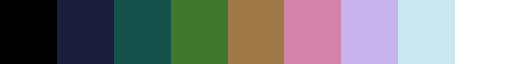

In [82]:
plt.get_cmap('cubehelix', 9)

In [83]:
model_cmap = {k:plt.get_cmap('cubehelix', 9)(i) for i, k in enumerate(results['Model'].unique())}

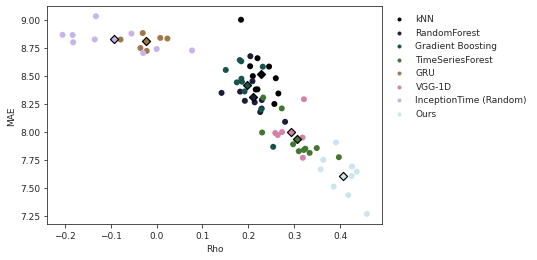

In [95]:
fig, ax = plt.subplots(1, 1, figsize=(6,4))
sns.scatterplot(x='Rho', y='MAE', hue='Model', data=results, palette=model_cmap, ax=ax, linewidth=0) 
ax.legend(bbox_to_anchor=(1, 1))
for mod in results['Model'].unique():
    dt = results.loc[results['Model']==mod, :]
    ax.scatter(dt['Rho'].mean(), dt['MAE'].mean(), s=33, marker='D', edgecolors='k', linewidths=1.2, color=model_cmap[mod])
fig.savefig(os.path.join(pfp, 'scatter_results_maeVrho_v52.pdf'), bbox_inches='tight')

<AxesSubplot:xlabel='MAE', ylabel='Rho'>

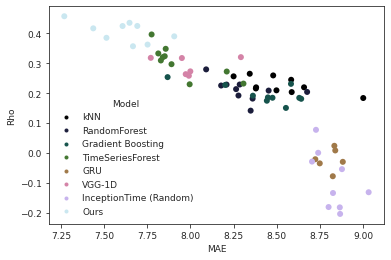

In [96]:
sns.scatterplot(x='MAE', y='Rho', hue='Model', data=results, palette=model_cmap, linewidth=0) 

# performance & output by train/test AND ptb+/-

In [38]:
mfp = '/home/ngrav/project/wearables/model_zoo'
bst_modelpkl = os.path.join(mfp, '213-itv52_InceptionTime_GA5.pkl')
bst_trainer = os.path.join(mfp, 'trainer_itv52_InceptionTime_GA5.pkl')
